<a href="https://colab.research.google.com/github/MagnsW/colab-Geophysics/blob/master/Analysis_Repeatability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import glob

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
filesindir = []
for file in glob.glob('/gdrive/My Drive/Colab Notebooks/input/*'):
    filesindir.append(file)
print(filesindir)

['/gdrive/My Drive/Colab Notebooks/input/POL_f3_on_POL_f0.txt', '/gdrive/My Drive/Colab Notebooks/input/RAM17_f3_on_POL_f0.txt', '/gdrive/My Drive/Colab Notebooks/input/RAM17_fanf3_on_POL_f0.txt', '/gdrive/My Drive/Colab Notebooks/input/RAM19_f3_on_POL_f0.txt', '/gdrive/My Drive/Colab Notebooks/input/RAM19_f3_on_POL_f0comb.txt', '/gdrive/My Drive/Colab Notebooks/input/RAM19_f3_on_RAM19_f0.txt']


In [0]:
def readtodataframe(file, scenario):
    path = '/gdrive/My Drive/Colab Notebooks/input/'
    filename = path + file + '.txt'
    column_names = ['BasShotNo', 'MonShotNo', 'BasRecvNo', 'MonRecvNo', 'OffsDiff', 'AzimDiff', 'CMPDist', 'CMPInDist', 'CMPCrDist', 'SouDist', 'SouInDist', 'SouCrDist', 'RecDist', 'RecInDist', 'RecCrDist', 'SouRecDist']
    rowstoskip = 2
    df_raw = pd.read_csv(filename, names=column_names, skiprows=rowstoskip, delim_whitespace=True)
    df_raw['Scenario'] = scenario
    return df_raw

In [0]:
df_raw_POL_f3_on_POL_f0 = readtodataframe('POL_f3_on_POL_f0', '8x75m on 8x75m')
df_raw_RAM19_f3_on_POL_f0 = readtodataframe('RAM19_f3_on_POL_f0', '19x37.5m on 8x75m')
df_raw_RAM19_f3_on_POL_f0comb = readtodataframe('RAM19_f3_on_POL_f0comb', '19x37.5m on 8x75m inc interleaved')
df_raw_RAM19_f3_on_RAM19_f0 = readtodataframe('RAM19_f3_on_RAM19_f0', '19x37.5m on 19x37.5m')
df_raw_RAM17_f3_on_POL_f0 = readtodataframe('RAM17_f3_on_POL_f0', '17x37.5m on 8x75m')
df_raw_RAM17_fanf3_on_POL_f0 = readtodataframe('RAM17_fanf3_on_POL_f0', '17x37.5m with fan on 8x75m')

In [0]:
def offset_split(df, channo):
    df['Channel Range'] = df['BasRecvNo'].apply(lambda x: '< '+str(channo) if ((x % 408 < channo) & (x % 408 > 0)) else '> '+str(channo))
    return df
    

In [0]:
chansplit = 100
df_raw_POL_f3_on_POL_f0 = offset_split(df_raw_POL_f3_on_POL_f0, chansplit)
df_raw_RAM17_f3_on_POL_f0 = offset_split(df_raw_RAM17_f3_on_POL_f0, chansplit)
df_raw_RAM17_fanf3_on_POL_f0 = offset_split(df_raw_RAM17_fanf3_on_POL_f0, chansplit)
df_raw_RAM19_f3_on_POL_f0 = offset_split(df_raw_RAM19_f3_on_POL_f0, chansplit)
df_raw_RAM19_f3_on_POL_f0comb = offset_split(df_raw_RAM19_f3_on_POL_f0comb, chansplit)
df_raw_RAM19_f3_on_RAM19_f0 = offset_split(df_raw_RAM19_f3_on_RAM19_f0, chansplit)

In [0]:
df_raw_POL_f3_on_POL_f0.replace(-999.25, np.nan, inplace=True)
df_raw_RAM17_f3_on_POL_f0.replace(-999.25, np.nan, inplace=True)
df_raw_RAM17_fanf3_on_POL_f0.replace(-999.25, np.nan, inplace=True) 
df_raw_RAM19_f3_on_POL_f0.replace(-999.25, np.nan, inplace=True)
df_raw_RAM19_f3_on_POL_f0comb.replace(-999.25, np.nan, inplace=True) 
df_raw_RAM19_f3_on_RAM19_f0.replace(-999.25, np.nan, inplace=True) 

In [0]:
df_combined = pd.concat([df_raw_POL_f3_on_POL_f0, 
                         df_raw_RAM19_f3_on_POL_f0, 
                         df_raw_RAM19_f3_on_POL_f0comb, 
                         df_raw_RAM17_f3_on_POL_f0, 
                         df_raw_RAM17_fanf3_on_POL_f0,
                         df_raw_RAM19_f3_on_RAM19_f0,])

In [0]:
def plot_dist(df, attrib, maxval, title, plttype='violin'):
    sns.set_style("darkgrid")
    sns.set_context('poster')
    sns.set_palette('Paired')
    plt.figure(figsize=(20,12))
    plt.title(title)
    plt.xticks(rotation=20)
    plt.gca().invert_yaxis()
    plt.ylim(maxval, -maxval/20)
    if plttype == 'violin':
        #sns.violinplot(data=df[df[attrib] <= maxval], x='Scenario', y=attrib, hue='Channel Range', split=True, cut=0, scale='count')
        #sns.violinplot(data=df[df[attrib] <= maxval], x='Scenario', y=attrib, split=True, cut=0, scale='count')
        sns.violinplot(data=df, x='Scenario', y=attrib, hue='Channel Range', split=True, cut=0, scale='count')
    else:
        sns.boxplot(data=df[df[attrib] <= maxval], x='Scenario', y=attrib, hue='Channel Range')

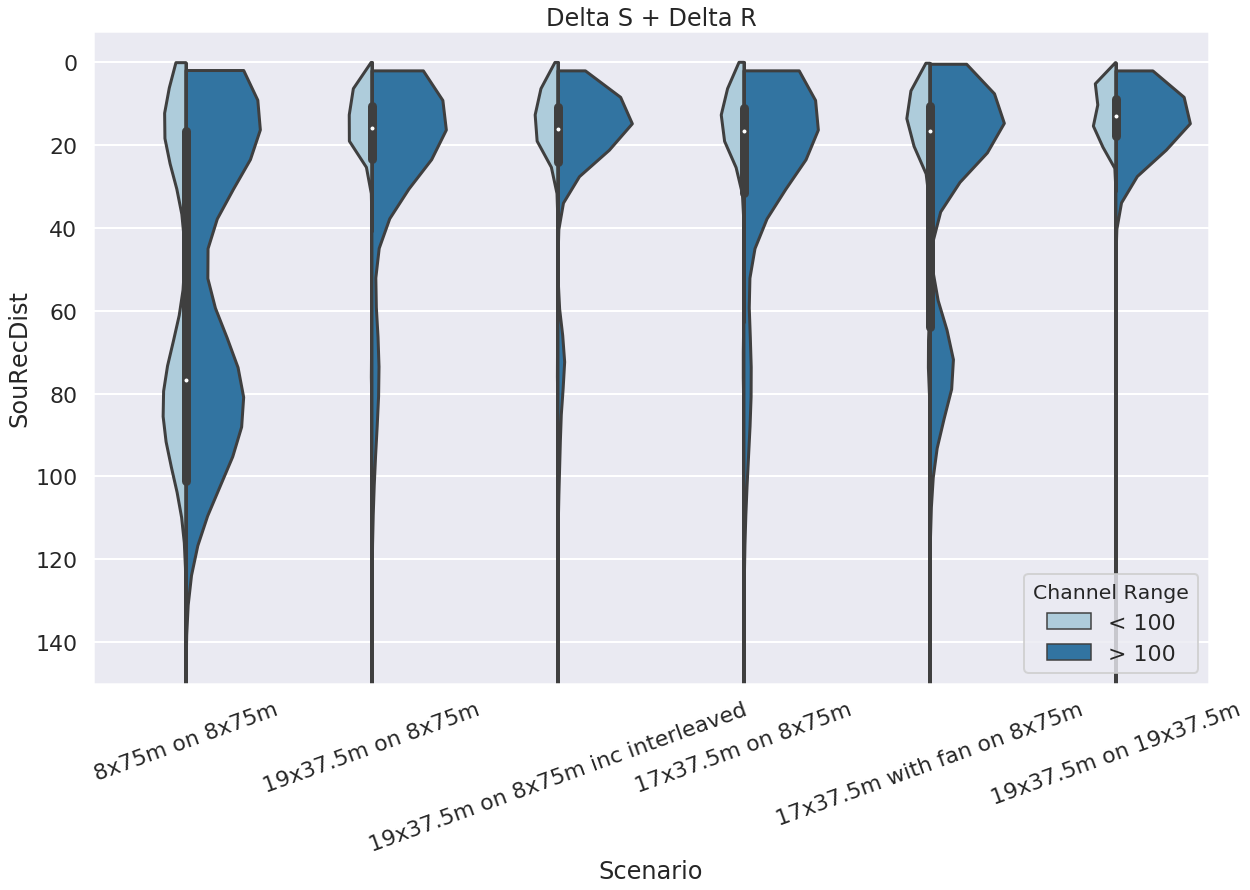

In [0]:
plot_dist(df_combined, 'SouRecDist', 150, 'Delta S + Delta R', plttype='violin')

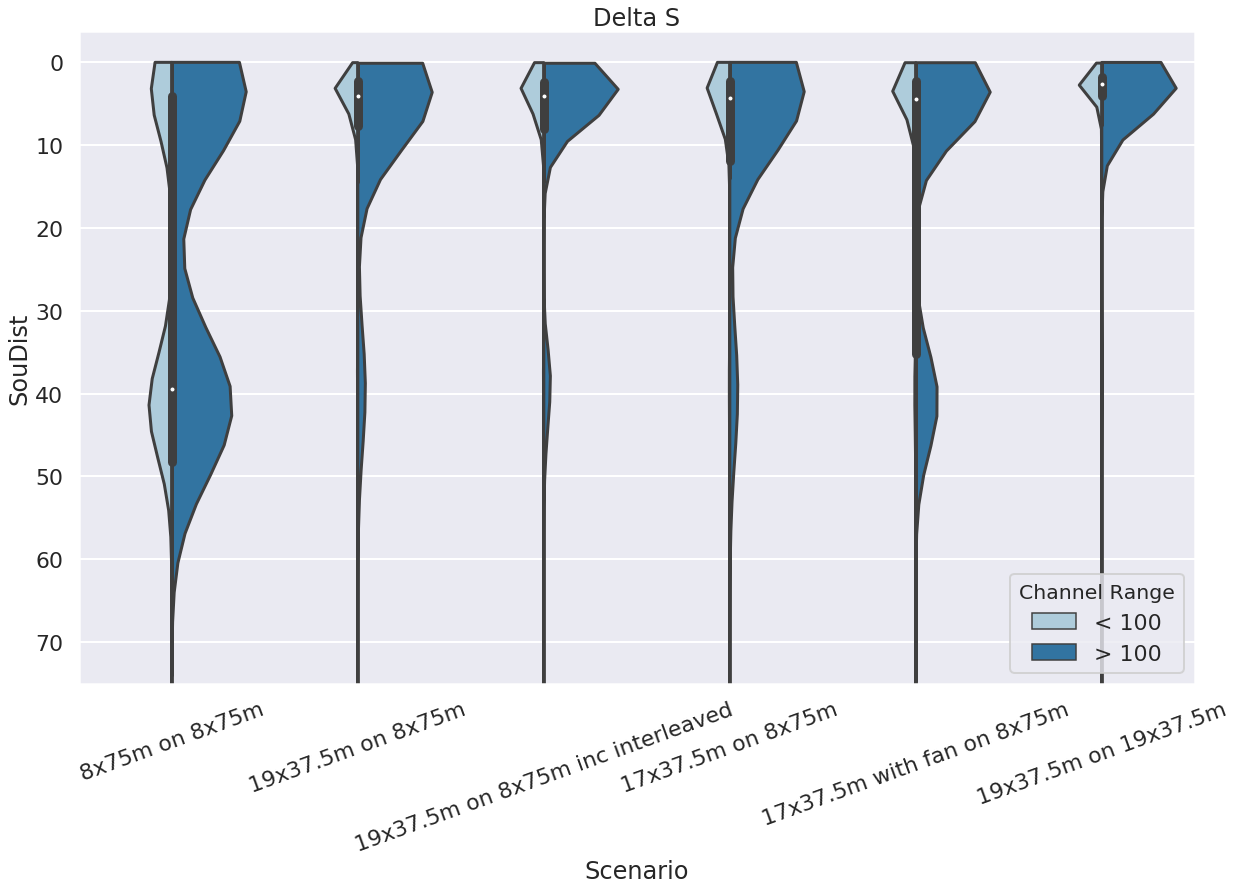

In [0]:
plot_dist(df_combined, 'SouDist', 75, 'Delta S', plttype='violin')

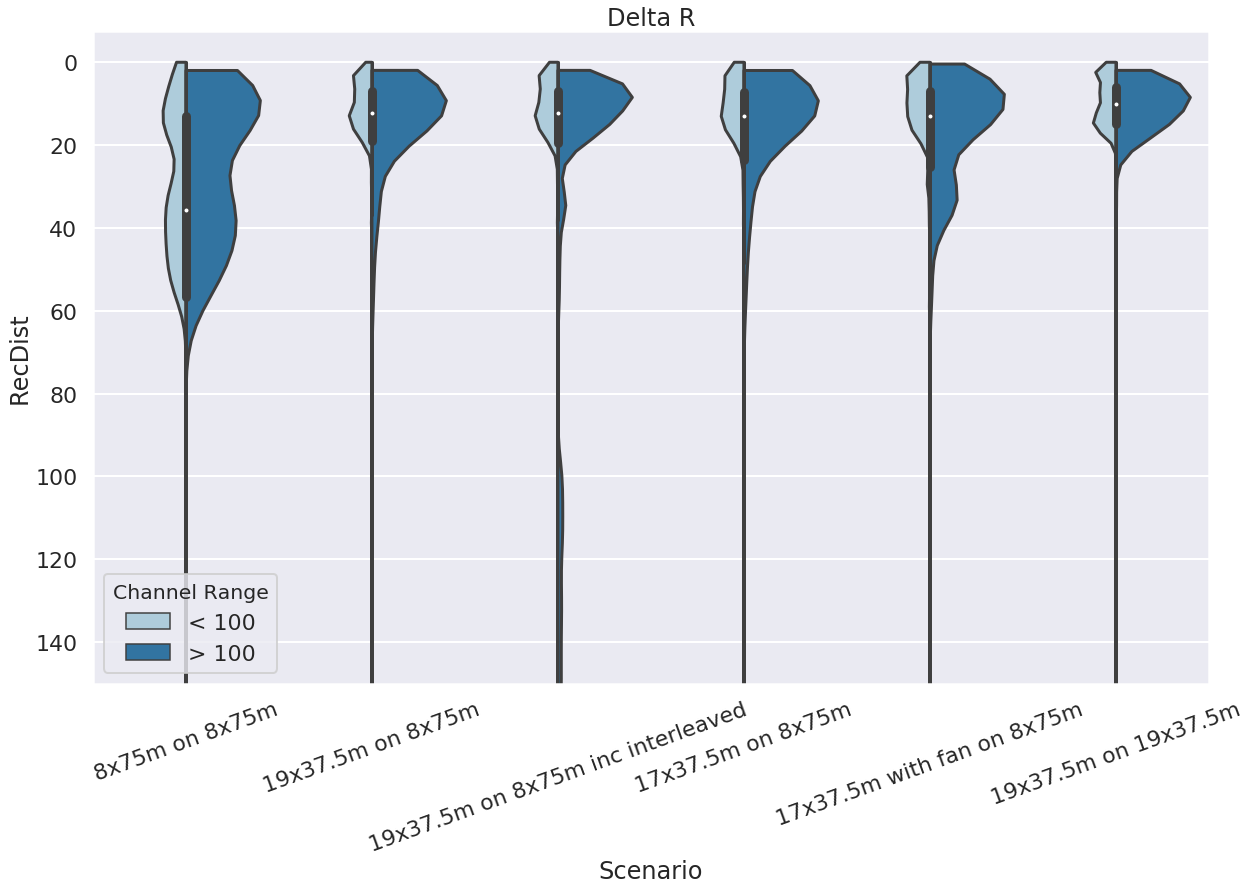

In [0]:
plot_dist(df_combined, 'RecDist', 150, 'Delta R', plttype='violin')

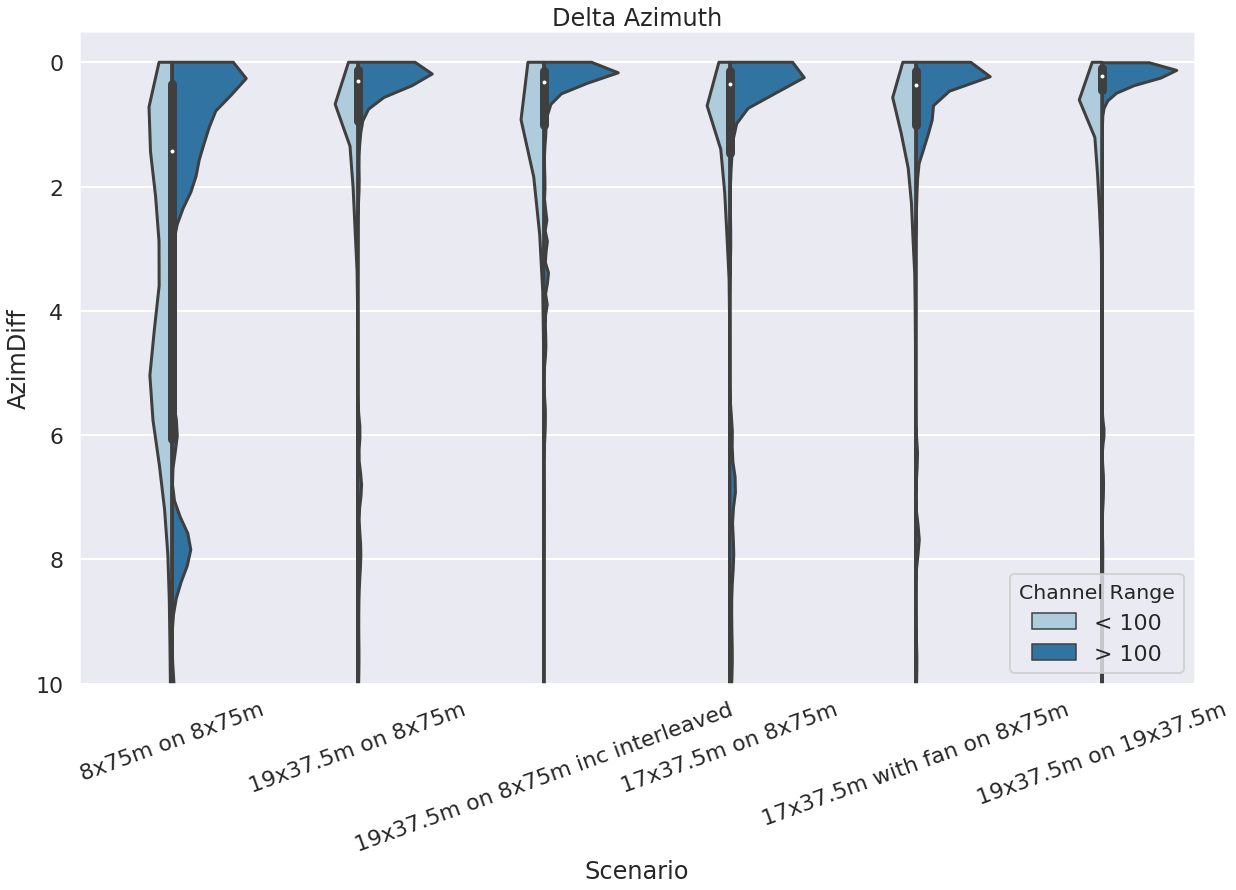

In [0]:
plot_dist(df_combined, 'AzimDiff', 10, 'Delta Azimuth', plttype='violin')

In [0]:
def make_summary(df, attribute):
    #summary = df.describe(percentiles=[0.1, 0.25, 0.5, 0.9])[['OffsDiff', 'AzimDiff', 'CMPDist', 'CMPInDist', 'CMPCrDist', 'SouDist', 'SouInDist', 'SouCrDist', 'RecDist', 'RecInDist', 'RecCrDist', 'SouRecDist']].round(decimals=1).T
    summary = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])[[attribute]].round(decimals=1)
    #summary['Scenario'] = df[['Scenario']].iloc[0,0]
    #summary = summary.set_index([attribute])
    summary = summary.T
    summary['Scenario'] = df[['Scenario']].iloc[0,0]
    summary = summary.set_index(['Scenario']).reset_index()
    return summary

In [0]:
def makefullsummary(attribute):
    summary = make_summary(df_raw_POL_f3_on_POL_f0, attribute)
    summary = summary.append(make_summary(df_raw_RAM19_f3_on_POL_f0, attribute), ignore_index=True)
    summary = summary.append(make_summary(df_raw_RAM19_f3_on_POL_f0comb, attribute), ignore_index=True)    
    summary = summary.append(make_summary(df_raw_RAM17_f3_on_POL_f0, attribute), ignore_index=True)
    summary = summary.append(make_summary(df_raw_RAM17_fanf3_on_POL_f0, attribute), ignore_index=True)
    summary = summary.append(make_summary(df_raw_RAM19_f3_on_RAM19_f0, attribute), ignore_index=True)
    return summary

In [0]:
def make_heatmap(df, caption):
    cm = sns.light_palette("red", as_cmap=True)
    s = df.style.set_caption(caption).background_gradient(cmap=cm).hide_index().hide_columns(['count'])
    #s = df.style.set_caption(caption).background_gradient(cmap=cm).hide_index()
    return s
    

In [0]:
summary_offsetdiff = makefullsummary('OffsDiff')
make_heatmap(summary_offsetdiff, 'Delta Offset')

Scenario,mean,std,min,10%,25%,50%,75%,90%,max
8x75m on 8x75m,20.9,18.1,0,1.8,4.4,16.9,35.1,45.2,74.9
19x37.5m on 8x75m,9.7,14.8,0,1,2.4,4.5,7.2,32.9,74.9
19x37.5m on 8x75m inc interleaved,10.2,15.2,0,1.1,2.5,4.8,7.8,31.4,74.9
17x37.5m on 8x75m,10.5,15.4,0,1,2.3,4.6,8,35,74.9
17x37.5m with fan on 8x75m,11.9,16.9,0,0.7,1.7,3.7,10.3,38.9,75
19x37.5m on 19x37.5m,5.5,7.9,0,0.9,2.2,4.1,6.2,8,73.7


In [0]:
summary_sourcerecdist = makefullsummary('SouRecDist')
make_heatmap(summary_sourcerecdist, 'Delta S + Delta R')

Scenario,mean,std,min,10%,25%,50%,75%,90%,max
8x75m on 8x75m,175,232.3,0.1,9.9,16.7,76.6,101.1,600.4,712.1
19x37.5m on 8x75m,88.5,181.6,0,7.3,10.7,16,23.4,520.6,709.4
19x37.5m on 8x75m inc interleaved,54,90.9,0,7.4,10.7,16.1,24.1,226.9,634.6
17x37.5m on 8x75m,116.7,208.7,0,7.4,10.9,16.6,31.7,537,710.4
17x37.5m with fan on 8x75m,61.3,135.4,0.2,6.9,10.6,16.7,63.8,81.5,706.7
19x37.5m on 19x37.5m,35,103.8,0.1,6.2,8.8,13,17.8,21.7,633.2


In [0]:
summary_sourcedist = makefullsummary('SouDist')
make_heatmap(summary_sourcedist, 'Delta S')

Scenario,mean,std,min,10%,25%,50%,75%,90%,max
8x75m on 8x75m,86.2,117.3,0,1.9,4.1,39.5,48.2,300.3,352
19x37.5m on 8x75m,41.7,92,0,1.3,2.3,4.1,7.7,261.8,347.8
19x37.5m on 8x75m inc interleaved,24.5,46.7,0,1.3,2.3,4.1,8.1,114.4,311.5
17x37.5m on 8x75m,55.9,105.7,0,1.2,2.3,4.3,11.9,266.7,350.3
17x37.5m with fan on 8x75m,29,68.9,0.1,1.4,2.3,4.5,35.2,44.5,352.2
19x37.5m on 19x37.5m,14.2,52.8,0,1.1,1.8,2.6,4.1,6.3,309.1


In [0]:
summary_recdist = makefullsummary('RecDist')
make_heatmap(summary_recdist, 'Delta R')

Scenario,mean,std,min,10%,25%,50%,75%,90%,max
8x75m on 8x75m,88.8,115.2,0,6.5,13,35.6,56.6,300.2,360.9
19x37.5m on 8x75m,46.8,89.7,0,4.2,7,12.2,18.9,257.4,364
19x37.5m on 8x75m inc interleaved,29.5,44.4,0,4.2,7,12.3,19.4,112.7,324.9
17x37.5m on 8x75m,60.8,103.1,0,4.4,7.2,12.9,23.7,273.3,364.1
17x37.5m with fan on 8x75m,32.3,66.7,0,3.6,6.9,12.9,25.4,38.7,362
19x37.5m on 19x37.5m,20.8,51.2,0,3.6,6.1,10,14.8,18.2,325


In [0]:
summary_azmdiff = makefullsummary('AzimDiff')
make_heatmap(summary_azmdiff, 'Delta Azimuth')

Scenario,mean,std,min,10%,25%,50%,75%,90%,max
8x75m on 8x75m,4,5.9,0,0.1,0.3,1.4,6.1,10.8,71.3
19x37.5m on 8x75m,1.5,2.9,0,0.1,0.1,0.3,0.9,6.8,66.8
19x37.5m on 8x75m inc interleaved,1.2,3.7,0,0.1,0.1,0.3,1,3.4,91.5
17x37.5m on 8x75m,2.2,3.9,0,0.1,0.1,0.4,1.5,8,69.3
17x37.5m with fan on 8x75m,1.2,2.4,0,0.1,0.1,0.4,1,2.2,56.3
19x37.5m on 19x37.5m,0.6,1.4,0,0,0.1,0.2,0.4,1.1,59.9


In [0]:
cm = sns.light_palette("green", as_cmap=True)
s = summary_sourcerecdist[['Scenario','count']].style.set_caption('Number of Traces').background_gradient(cmap=cm).hide_index()

In [0]:
s

Scenario,count
8x75m on 8x75m,1.35129e+06
19x37.5m on 8x75m,1.44221e+06
19x37.5m on 8x75m inc interleaved,1.46161e+06
17x37.5m on 8x75m,1.44222e+06
17x37.5m with fan on 8x75m,1.40941e+06
19x37.5m on 19x37.5m,1.4636e+06


In [0]:
#df_combined.describe()

In [0]:
#df_combined.median()